# Data analysis and pre processing
This notebook explores the input data to perform feature engineering.

#### Libraries and options

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

%matplotlib inline
sns.set_style("ticks")

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [2]:
def list_directory_tree_with_os_walk(starting_directory):
    for root, directories, files in os.walk(starting_directory):
        print(f"Directory: {root}")
        for file in files:
            print(f"  File: {file}")
# Check the directory
starting_directory_noe = 'C:/Users/NOE/source/repos/Energy-forecasting-NTNU/data/'
os.chdir(starting_directory_noe)

list_directory_tree_with_os_walk('.')

Directory: .
  File: .DS_Store
  File: Readme.md
  File: read_files.ipynb
  File: sample_submission.csv
  File: test.csv
Directory: .\.ipynb_checkpoints
  File: Data_exploration-checkpoint.ipynb
  File: Readme-checkpoint.md
  File: read_files-checkpoint.ipynb
Directory: .\A
  File: train_targets.parquet
  File: X_test_estimated.parquet
  File: X_train_estimated.parquet
  File: X_train_observed.parquet
Directory: .\B
  File: train_targets.parquet
  File: X_test_estimated.parquet
  File: X_train_estimated.parquet
  File: X_train_observed.parquet
Directory: .\C
  File: train_targets.parquet
  File: X_test_estimated.parquet
  File: X_train_estimated.parquet
  File: X_train_observed.parquet
Directory: .\catboost_info
  File: catboost_training.json
  File: learn_error.tsv
  File: time_left.tsv
Directory: .\catboost_info\learn
  File: events.out.tfevents
Directory: .\catboost_info\tmp
Directory: .\Hugo
  File: notebook_hugo.ipynb
  File: read_files.ipynb
Directory: .\Noe
  File: Data_explorat

---

## Functions

This section contains all the functions that are used for further data analysis/processing


In [45]:
def read_data_location(location: str):
    """
    Description
    -----------
    Read data from Parquet files located in a specified directory.

    This function reads the training target, observed training data, estimated training data,
    and estimated test data from Parquet files located in the specified directory.
    
    Parameters
    ----------
    - `location` (str): The directory path where the Parquet files are located.

    Returns
    -------
    - A tuple containing the following DataFrames:
      - `train_target` (pandas.DataFrame): Training target data.
      - `X_train_observed` (pandas.DataFrame): Observed training data.
      - `X_train_estimated` (pandas.DataFrame): Estimated training data.
      - `X_test_estimated` (pandas.DataFrame): Estimated test data.

    Example
    -------
    ```python
    data_location = '/path/to/data_directory'
    train_target, X_train_observed, X_train_estimated, X_test_estimated = read_data_location(data_location)
    ```
    """
    train_target = pd.read_parquet(location+'/train_targets.parquet')
    X_train_observed = pd.read_parquet(location+'/X_train_observed.parquet')
    X_train_estimated = pd.read_parquet(location+'/X_train_estimated.parquet')
    X_test_estimated = pd.read_parquet(location+'/X_test_estimated.parquet')
    return(train_target, X_train_observed, X_train_estimated, X_test_estimated)



def find_low_correlation_columns(dataframe, threshold, verbose = True):
    """
    Description
    -----------
    Find and remove columns in a DataFrame with low absolute correlation coefficients.

    This function calculates the pairwise correlation coefficients between columns in a DataFrame and
    removes columns that have absolute correlation coefficients equal to or above the specified threshold.
    It provides the option to print the removed columns for reference.

    Parameters
    ----------
    - `dataframe` (pandas.DataFrame): The DataFrame for which low correlation columns should be found.
    - `threshold` (float): The threshold for absolute correlation coefficients. Columns with absolute
                      correlation coefficients greater than or equal to this threshold will be removed.
    - `verbose` (bool, optional): If True, print information about removed columns. Default is True.

    Returns
    -------
    - List of column names that remain in the DataFrame after removing low correlation columns.

    Example
    -------
    ```python
    import pandas as pd

    data = {'feature1': [1, 2, 3, 4, 5],
            'feature2': [2, 3, 4, 5, 6],
            'feature3': [5, 6, 7, 8, 9]}

    df = pd.DataFrame(data)
    threshold = 0.7

    selected_columns = find_low_correlation_columns(df, threshold)
    ```
    """
    
    correlation_matrix = dataframe[:].corr()

    feature_list = list(correlation_matrix.columns)
    removed_list = []
    for reference_index in range(len(feature_list)):
        reference_feature = feature_list[reference_index]

        # Check if this feature has not already been removed
        if reference_feature not in removed_list:
            for compared_index in range(reference_index+1,len(feature_list)):
                compared_feature = feature_list[compared_index]

                # Check if this feature has not already been removed
                if compared_feature not in removed_list:

                    # Get correlation coefficient
                    coefficient = correlation_matrix.loc[reference_feature,compared_feature]

                    # Remove column if it's a NaN
                    if pd.isna(coefficient):
                        removed_list.append(compared_feature)
                        if verbose : print(f"Removed {compared_feature} because it is NaN")
                        
                    # Remove if it is above threshold
                    if np.abs(coefficient)>=threshold:
                        removed_list.append(compared_feature)
                        if verbose : print(f"Removed \t{compared_feature}\tbecause it is correlated to\t{reference_feature}")
    
    
    output_list = feature_list.copy()
    for element in removed_list:
        output_list.remove(element)
        
    return list(output_list)





def fill_nan(Dataframe: pd.DataFrame, feature: str):
    """
    Description
    -----------
    Fill missing (`NaN`) values in a specified feature of a DataFrame using forward-fill or backward-fill.

    This function checks for missing values in the specified feature and fills them using forward-fill (`ffill`)
    or backward-fill (`bfill`) if necessary. It also provides information about the filled method and missing data.

    Parameters
    ----------
    - `Dataframe` (pandas.DataFrame): The DataFrame containing the feature with missing values.
    - `feature` (str): The name of the feature in the DataFrame.

    Returns
    -------
    - None, but it updates the input DataFrame in place by filling missing values.

    Example
    -------
    ```python
    import pandas as pd

    data = {'date': pd.date_range(start='2023-01-01', periods=100, freq='D'),
            'value': [1, 2, np.nan, 4, np.nan, 6, 7, 8, np.nan, 10]}

    df = pd.DataFrame(data)
    feature = 'value'

    fill_nan(df, feature)
    ```
    """
    it_na = np.where(Dataframe[feature].isna())[0]
    
    #If missing value
    if len(it_na != 0):
        print("Missing data in",feature," size ",it_na.size," out of", Dataframe.shape[0])
        new_column = Dataframe[feature].fillna(method='ffill')
        method = 'ffill'
        
        if((np.any(new_column.isna()) == True)): 
            method = 'bfill'
            new_column = Dataframe[feature].fillna(method='bfill')
           
        #plt.plot(new_column)
        #plt.scatter(it_na,new_column[it_na],s=10, c='red')
    
        if (np.any(new_column.isna()) == False):
            print("Filled with",method,"method")
            Dataframe[feature] = new_column
        else:
            print("Still Nan values")



def select_and_resample(Xdf: pd.DataFrame,Ydf: pd.DataFrame):
    """
    Description
    -----------
    Select and resample time series data.

    This function selects data from two time series dataframes, `Xdf` and `Ydf`, where there is a match in time values.
    It then resamples `Ydf` to a 15-minute interval using linear interpolation and returns the resulting time-aligned data.
    The output data contains only streaks of minutes `[15, 30, 45, 00]`.

    Parameters
    ----------
    - `Xdf` (pandas.DataFrame): The first time series dataframe containing `'date_forecast'` column.
    - `Ydf` (pandas.DataFrame): The second time series dataframe containing `'time'` column.

    Returns
    -------
    - Tuple of two pandas DataFrames:
      - The selected and filtered X values, with a 15-minute interval.
      - The resampled Y values, matching the selected X values.

    Example
    -------
    ```python
    Xdf = pd.DataFrame({'date_forecast': pd.date_range(start='2023-01-01', periods=100, freq='15T')})
    Ydf = pd.DataFrame({'time': pd.date_range start='2023-01-01', periods=200, freq='30T')})
    selected_X, selected_Y = select_and_resample(Xdf, Ydf)
    ```
    """
    
    ##### Select Y values where there are X values :
    Y_in_X_times = Ydf['time'].isin(Xdf['date_forecast'])
    Selected_Y = Ydf[Y_in_X_times].reset_index(drop=True)
    
    ##### Select X values where there are Y values
    # ceil the date forecast to the hour in Xdf
    Xdf['hourly_forecast'] = Xdf['date_forecast'].dt.ceil('H')
    X_in_Y_times = Xdf['hourly_forecast'].isin(Selected_Y['time'])
    Selected_X = Xdf[X_in_Y_times].reset_index(drop=True).drop(columns=['hourly_forecast'])

    #### Filter X values to get 4 consecutive 15 minutes
    valid_minutes = [15, 30, 45, 0]
    # Calculate the difference in minutes between consecutive rows
    Selected_X = Selected_X.sort_values('date_forecast')
    Selected_X['minute_diff'] = Selected_X['date_forecast'].diff().dt.total_seconds() / 60
    # Create a mask to identify valid minutes
    valid_mask = Selected_X['minute_diff'].isin(valid_minutes)
    # Create a mask to identify the start of consecutive valid minute streaks
    streak_start_mask = valid_mask & (~valid_mask.shift(1, fill_value=False))
    # Create a mask to identify the end of consecutive valid minute streaks
    streak_end_mask = valid_mask & (~valid_mask.shift(-1, fill_value=False))
    # Merge the start and end masks to get the full streak mask
    consecutive_streak_mask = streak_start_mask | streak_end_mask
    # Extend the streaks to include isolated values
    consecutive_streak_mask = consecutive_streak_mask | consecutive_streak_mask.shift(1, fill_value=False) | consecutive_streak_mask.shift(-1, fill_value=False)
    # Repeatedly extend the streaks until no more can be extended
    while True:
        extended_streaks = consecutive_streak_mask | consecutive_streak_mask.shift(1, fill_value=False) | consecutive_streak_mask.shift(-1, fill_value=False)
        if extended_streaks.equals(consecutive_streak_mask):
            break
        consecutive_streak_mask = extended_streaks
    # Identify the cases where the streaks start with non-15 minutes
    non_15_start = valid_mask & (streak_start_mask | streak_end_mask)
    consecutive_streak_mask = consecutive_streak_mask | non_15_start

    Selected_X_filtered = Selected_X[consecutive_streak_mask].drop(columns='minute_diff')

    #### Resample Ydf with 15 minute interval 
    Selected_Y.set_index('time', inplace=True)
    Selected_Y_resampled = Selected_Y.resample('15T').interpolate(method='linear') #  use 'nearest' for flatter interpolation
    Selected_Y_resampled = Selected_Y_resampled.reset_index()

    # Select Y resampled values where there are X values :
    Y_in_X_times_resampled = Selected_Y_resampled['time'].isin(Selected_X_filtered['date_forecast'])
    Selected_Y = Selected_Y_resampled[Y_in_X_times_resampled].reset_index(drop=True)
    # Again the other way round to remove data that passed through the filter
    Selected_X = Selected_X_filtered[Selected_X_filtered['date_forecast'].isin(Selected_Y['time'])].reset_index(drop=True)


    return(Selected_X[1:], Selected_Y[1:])  # remove first row which always starts with a 00

def remove_consecutive_identical_values(df: pd.DataFrame, feature: str):
    """
    Description
    -----------
    Remove rows with consecutive identical values in a specified feature of a DataFrame.

    Paramters
    ---------
    - `df` (pandas.DataFrame): The DataFrame to process.
    - `feature` (str): The name of the feature in the DataFrame.

    Returns
    -------
    - `pandas.DataFrame`: The filtered DataFrame with consecutive identical values removed.

    Example
    -------
    ```python
    import pandas as pd

    data = {'time': pd.date_range(start='2023-01-01', periods=100, freq='15T'),
            'value': [1, 2, 2, 3, 3, 3, 4, 4, 4, 4]}

    df = pd.DataFrame(data)
    feature = 'value'

    filtered_df = remove_consecutive_identical_values(df, feature)
    ```
    """
    # Identify rows with consecutive identical values in the specified feature
    mask = df[feature] != df[feature].shift(+1)

    # Filter and remove rows with consecutive identical values
    filtered_df = df[mask]

    return filtered_df

def remove_consecutive_identical_values_keep_zeros(df: pd.DataFrame, feature: str):
    """
    Description
    -----------
    Remove rows with consecutive identical values (excluding 0) in a specified feature of a DataFrame.

    Parameters
    ----------
    - `df` (pandas.DataFrame): The DataFrame to process.
    - `feature` (str): The name of the feature in the DataFrame.

    Returns
    -------
    - `pandas.DataFrame`: The filtered DataFrame with consecutive identical values (excluding 0) removed.

    Example
    -------
    ```python
    import pandas as pd

    data = {'time': pd.date_range(start='2023-01-01', periods=100, freq='15T'),
            'value': [1, 2, 2, 3, 3, 3, 4, 4, 0, 0, 0, 4, 4]}

    df = pd.DataFrame(data)
    feature = 'value'

    filtered_df = remove_consecutive_identical_values(df, feature)
    ```
    """
    # Identify rows with consecutive identical values in the specified feature
    mask = (df[feature] != df[feature].shift(+1)) | (df[feature] == 0)

    # Filter and remove rows with consecutive identical values, excluding 0
    filtered_df = df[mask]

    return filtered_df


def select_o_clock(dataframe: pd.DataFrame, feature: str) -> pd.DataFrame:
    """
    Description
    -----------
    Select rows from a DataFrame where the time in the specified feature is a round hour (minute and second are 0) and sort them by the 'feature' column.

    Parameters
    ----------
    - `dataframe` (pandas.DataFrame): The DataFrame to process.
    - `feature` (str): The name of the feature column containing time values.

    Returns
    -------
    - `pandas.DataFrame`: The filtered DataFrame with rows where the time is a round hour, sorted by the 'feature' column.

    Example
    -------
    ```python
    import pandas as pd

    data = {'time_column': pd.date_range(start='2023-01-01', periods=100, freq='H')}

    df = pd.DataFrame(data)
    feature = 'time_column'

    filtered_df = select_o_clock(df, feature)
    ```
    """
     # Check if the feature column exists in the DataFrame
    if feature not in dataframe.columns:
        raise ValueError(f"'{feature}' column not found in the DataFrame")

    # Check if the feature column is of datetime type
    if not pd.api.types.is_datetime64_any_dtype(dataframe[feature]):
        raise ValueError(f"'{feature}' column should be of datetime type")

    # Filter the DataFrame to select rows with round-hour times
    filtered_df = dataframe[dataframe[feature].dt.minute == 0 & (dataframe[feature].dt.second == 0)]
    
    # Sort the filtered DataFrame by the 'feature' column
    filtered_df = filtered_df.sort_values(by=feature)

    return filtered_df


## Data exploration

### Plot all the features
This only plots all the features for a given location. It can be pretty slow but helps to visualize the possible issues and pre-processing.

In [3]:
location = 'A'

train_target = pd.read_parquet(location+'/train_targets.parquet')
X_train_estimated = pd.read_parquet(location+'/X_train_estimated.parquet')
X_train_observed = pd.read_parquet(location+'/X_train_observed.parquet')
X_test_estimated = pd.read_parquet(location+'/X_test_estimated.parquet')

In [ ]:
features = X_train_observed.keys()[1:] 

# Plotting train target and all training features
fig, axs = plt.subplots(len(features)+1, 1, figsize=(20, 120), sharex=False)
fig.tight_layout(pad=5.0)
# Plot target
train_target[['time', 'pv_measurement']].set_index('time').plot(ax=axs[0], title='Target '+str(location), color='red')

for k,feature_name in enumerate(features):
    X_train_observed[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[k+1], title=feature_name, color='red')
    X_train_estimated[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[k+1], title=feature_name, color='blue')
plt.show()

### Correlation between features
To get a better understanding at the correlation between all features we will show the correlation matrix. We will then remove the features that have high correlation coefficient as they would only make the model more complex without providing extra information:
- __correlation coefficient = 1__ : the two features are exactly the same (to a scale factor). This can be seen for all the pressure features. Only one feature should be kept
- __correlation coefficient > 0.9__ : the features are highly correlated, and contain almost identical values. This can be seen for `dew_point` and `absolute_humidity` for example. Keeping only one of the two should be enough for the model.
- __correlation coefficient < 0__ : the two features evolve in oposite directions (one goes down when the other increases). It can be seen for the features `is_in_shadow` and `sun_elevation` for example.
- __correlation coefficient = `NaN`__ : calculation failed, there is probably missing data.

In [ ]:
location = 'A'

train_target = pd.read_parquet(location+'/train_targets.parquet')
X_train_estimated = pd.read_parquet(location+'/X_train_estimated.parquet')
X_train_observed = pd.read_parquet(location+'/X_train_observed.parquet')
X_test_estimated = pd.read_parquet(location+'/X_test_estimated.parquet')


# The data to plot
df = X_train_observed   

# Exclude the first column (date forecast, it's the time axis)
columns_to_include = df.columns[:]

# Calculate the correlation matrix for selected columns
correlation_matrix = df[columns_to_include].corr()

# Set up the Seaborn heatmap
plt.figure(figsize=(40, 40))
sns.set(font_scale=1)      # Adjust the font scale

# Set up the Seaborn heatmap
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    linewidths=1,
    square=True,
    cbar_kws={"shrink": 0.7},
    fmt='.2f'
)

plt.title("Correlation Matrix")
plt.show()

We will now focus on removing the highly correlated features. For that, we use the following function :

Removed elevation:m because it is NaN
Removed snow_density:kgm3 because it is NaN
Removed snow_drift:idx because it is NaN
Removed 	dew_point_2m:K	because it is correlated to	absolute_humidity_2m:gm3
Removed 	t_1000hPa:K	because it is correlated to	absolute_humidity_2m:gm3
Removed 	clear_sky_rad:W	because it is correlated to	clear_sky_energy_1h:J
Removed 	diffuse_rad:W	because it is correlated to	clear_sky_energy_1h:J
Removed 	diffuse_rad_1h:J	because it is correlated to	clear_sky_energy_1h:J
Removed 	direct_rad_1h:J	because it is correlated to	direct_rad:W
Removed 	total_cloud_cover:p	because it is correlated to	effective_cloud_cover:p
Removed 	is_in_shadow:idx	because it is correlated to	is_day:idx
Removed 	pressure_100m:hPa	because it is correlated to	msl_pressure:hPa
Removed 	pressure_50m:hPa	because it is correlated to	msl_pressure:hPa
Removed 	sfc_pressure:hPa	because it is correlated to	msl_pressure:hPa
32 features remaining


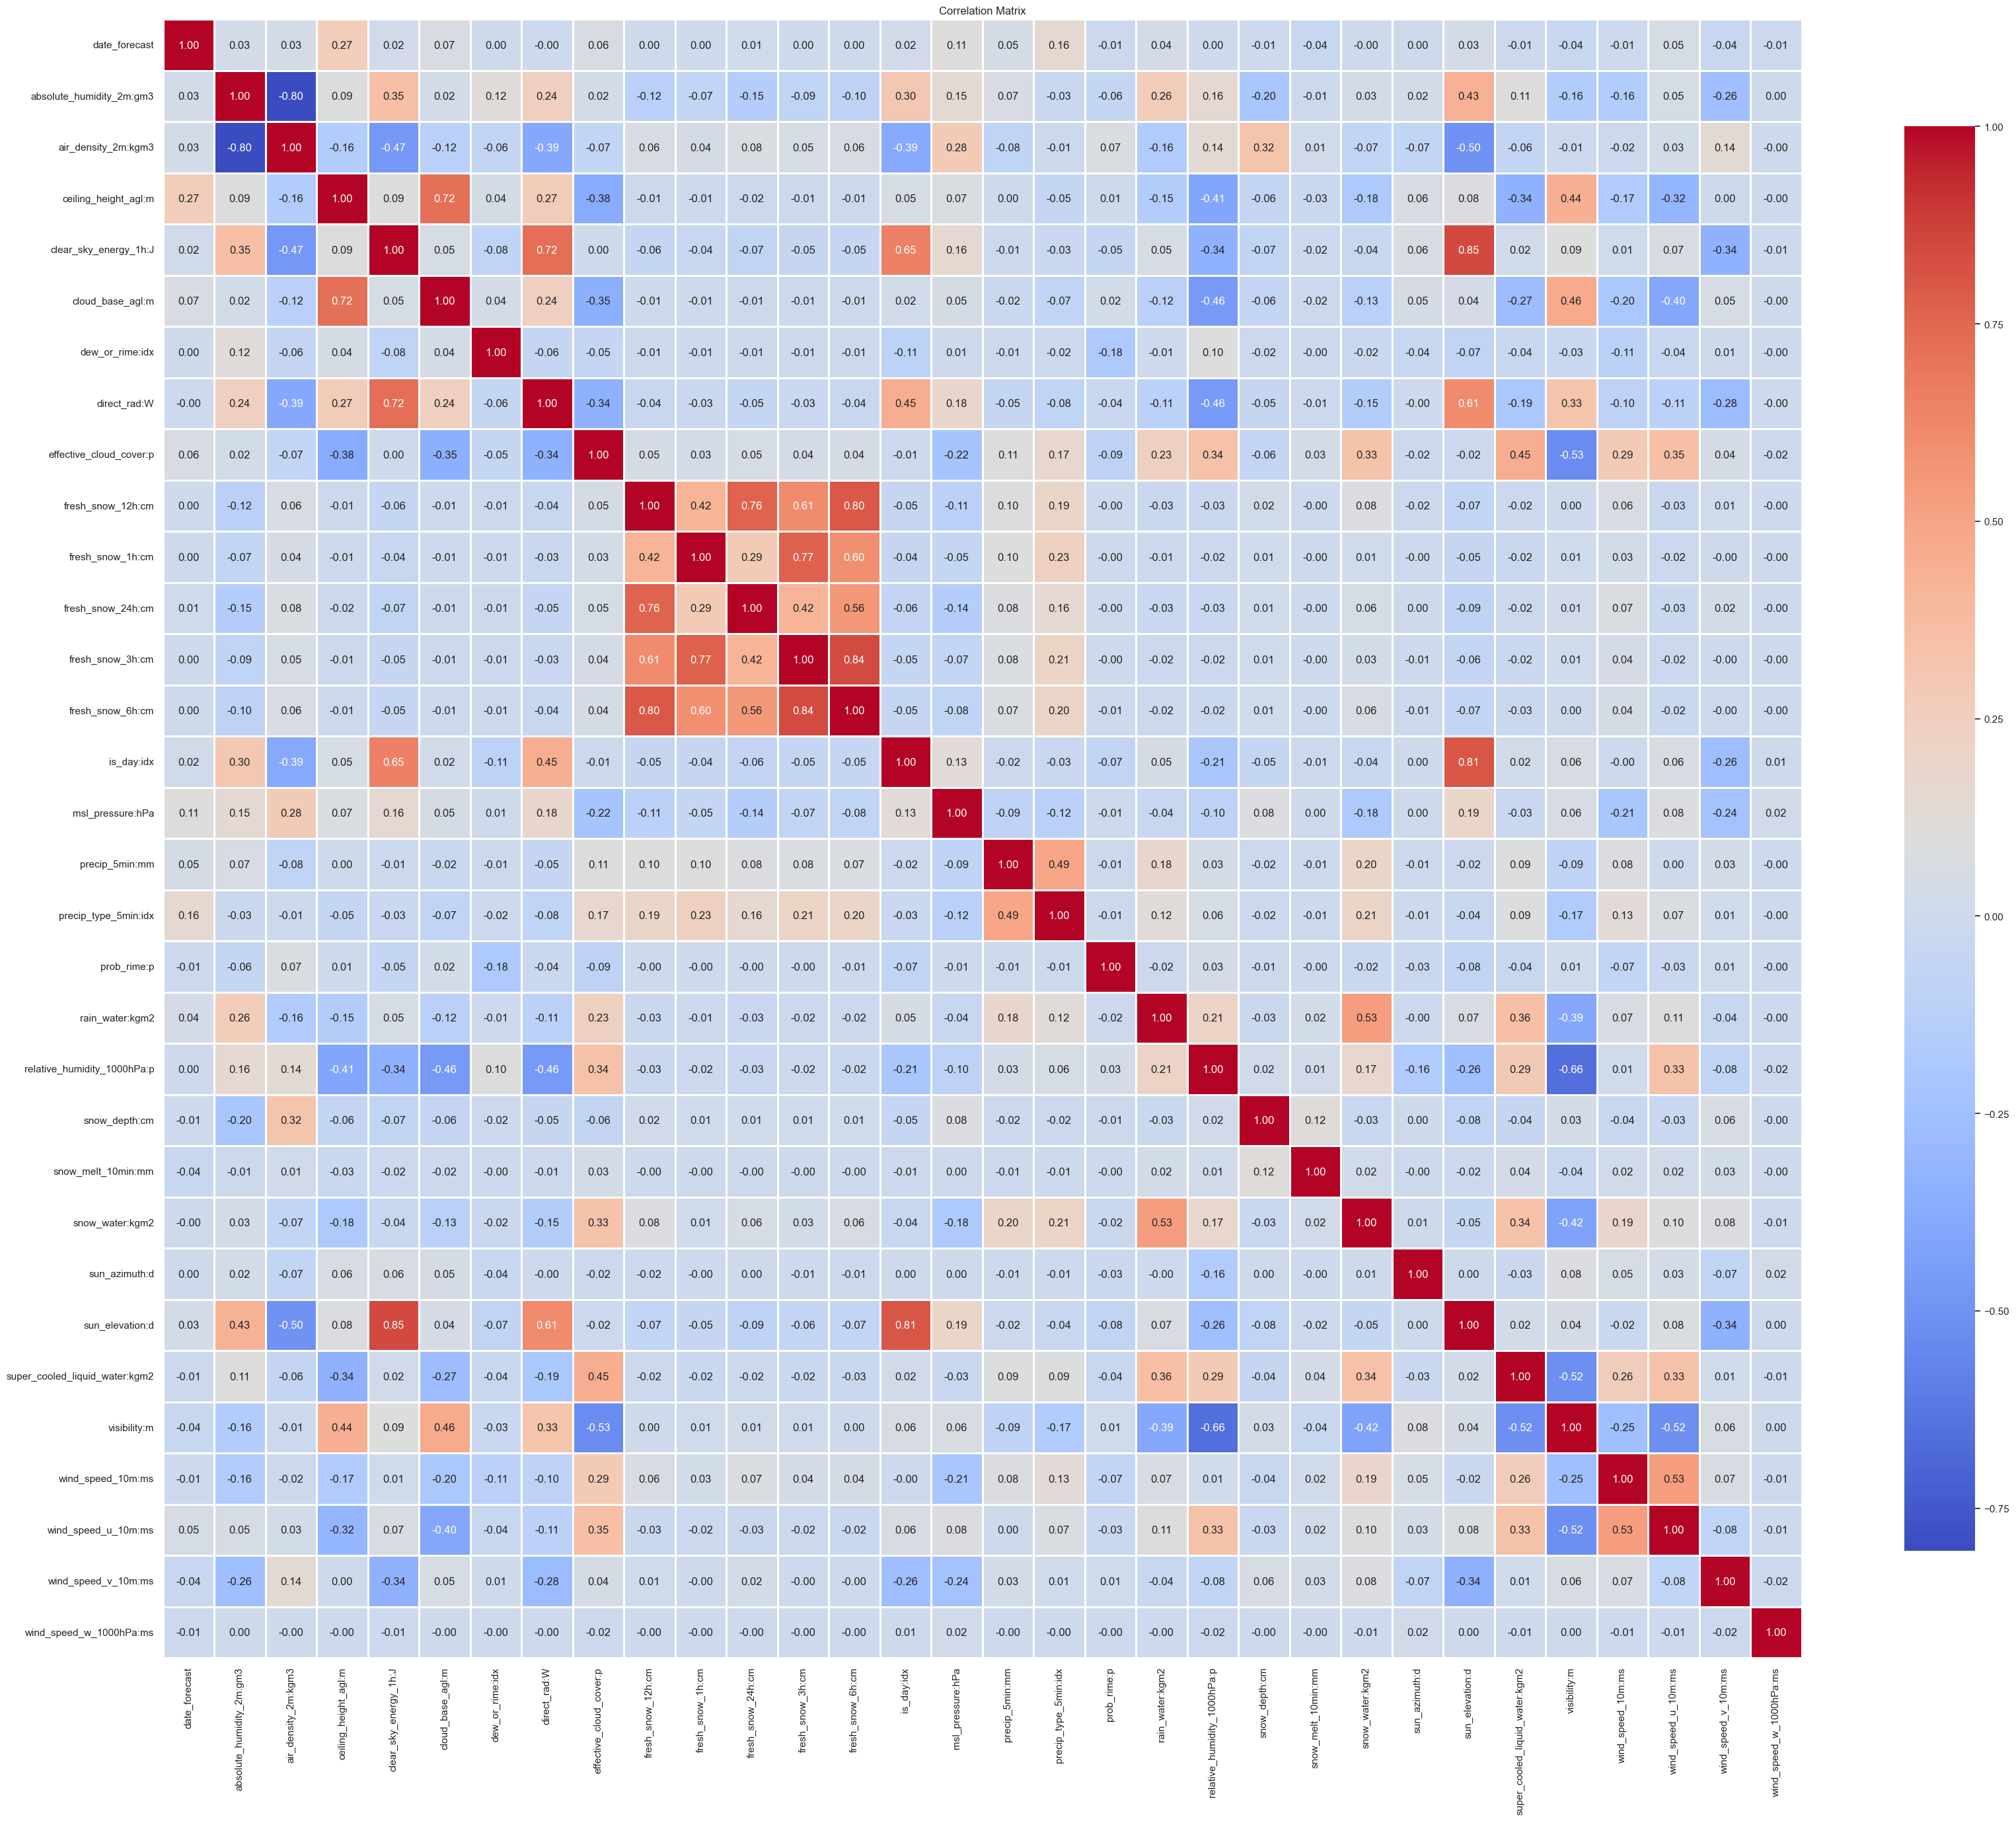

In [5]:
features = find_low_correlation_columns(X_train_observed,threshold=0.9)
print(f"{len(features)} features remaining")


# We now compute another correlation matrix to make sure that we excluded the correct features
# Select the non correlated features
columns_to_include = list(features)

# Calculate the correlation matrix for selected columns
correlation_matrix_filtered = df[columns_to_include].corr()

# Set up the Seaborn heatmap
plt.figure(figsize=(40, 40))
sns.set(font_scale=1)      # Adjust the font scale

# Set up the Seaborn heatmap
sns.heatmap(
    correlation_matrix_filtered,
    annot=True,
    cmap='coolwarm',
    linewidths=1,
    square=True,
    cbar_kws={"shrink": 0.7},
    fmt='.2f'
)

plt.title("Correlation Matrix")
plt.show()

There are still `NaN` values in the data (both features and target data) that we need to replace.

In [7]:
location = 'C'

train_target = pd.read_parquet(location+'/train_targets.parquet')
X_train_observed = pd.read_parquet(location+'/X_train_observed.parquet')
X_train_estimated = pd.read_parquet(location+'/X_train_estimated.parquet')
X_test_estimated = pd.read_parquet(location+'/X_test_estimated.parquet')


dataframes = [train_target,X_train_observed,X_train_estimated,X_test_estimated]
dataframe_names = ["train_target","X_train_observed","X_train_estimated","X_test_estimated"]
index = 0
FEATURES = [] # Contains the list of useful features for each dataframe

threshold = 0.9

for dataframe in dataframes:
    print("** WORKING ON "+dataframe_names[index]+"**")
    features = find_low_correlation_columns(dataframe,threshold,verbose=False)
    FEATURES.append(features)
    for feature in features:
        fill_nan(dataframe,feature)
    index+=1

** WORKING ON train_target**
Missing data in pv_measurement  size  6060  out of 32155
Filled with bfill method
** WORKING ON X_train_observed**


C:\Users\NOE\AppData\Local\Temp\ipykernel_9336\633608867.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  new_column = Dataframe[feature].fillna(method='ffill')
C:\Users\NOE\AppData\Local\Temp\ipykernel_9336\633608867.py:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  new_column = Dataframe[feature].fillna(method='bfill')


Missing data in ceiling_height_agl:m  size  19923  out of 116825
Filled with ffill method
Missing data in cloud_base_agl:m  size  8512  out of 116825
Filled with ffill method
** WORKING ON X_train_estimated**
Missing data in ceiling_height_agl:m  size  4596  out of 17576
Filled with ffill method
Missing data in cloud_base_agl:m  size  2804  out of 17576
Filled with ffill method
** WORKING ON X_test_estimated**
Missing data in ceiling_height_agl:m  size  849  out of 2880
Filled with bfill method
Missing data in cloud_base_agl:m  size  375  out of 2880
Filled with ffill method


In [20]:
YData = train_target
XTrain = pd.concat([x_df])[FEATURES[1]]

# Make sure that the dates are in the correct order
YData.sort_values(by="time", inplace=True)
XTrain.sort_values(by="date_forecast", inplace=True)

# Now, we have to interpolate YData_selected to match the time interval of XData_selected
# First, ensure "time" column in YData_selected is in datetime format
YData['time'] = pd.to_datetime(YData['time'])
YData.set_index('time', inplace=True)
# Resample with a 15 minute time interval
YData_resampled = YData.resample('15T').interpolate(method='nearest') #  use 'linear' for better interpolation
YData_resampled = YData_resampled.reset_index()



# Extract the start and end dates from YData
start_date_Y = YData_resampled["time"].min()
end_date_Y = YData_resampled["time"].max()

# Extract the start and end dates from XData
start_date_X = XTrain["date_forecast"].min()
end_date_X = XTrain["date_forecast"].max()

# Only select dates where we have data for X and Y
start_date = max(start_date_Y,start_date_X)
end_date = min(end_date_Y,end_date_X)

# Select XData within the specified date range
XData_selected = XTrain[(XTrain["date_forecast"] >= start_date) & (XTrain["date_forecast"] <= end_date)]
YData_selected = YData_resampled[(YData_resampled["time"] >= start_date) & (YData_resampled["time"] <= end_date)]

XData_selected = XData_selected.drop(columns='date_forecast')
YData_selected = YData_selected['pv_measurement']

# Replace colons in the feature names
XData_selected.columns = [column.replace(":","_") for column in XData_selected.columns]

We can now train the light gbm model

In [9]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

In [21]:
# Split dataset in train and test
X_train, X_test, Y_train, Y_test = train_test_split(XData_selected,YData_selected,
                                                    test_size=0.2,
                                                    random_state=RANDOM_SEED,
                                                    shuffle=True)


In [31]:
# Convert data to LightGBM Dataset format
train_data = lgb.Dataset(X_train, label=Y_train)
test_data = lgb.Dataset(X_test, label=Y_test)

# Set LightGBM hyperparameters
params = {
    "objective": "regression",
    "metric": "mse",
    "num_leaves": 1000,
    "learning_rate": 0.05,
}

# Train the LightGBM model
model = lgb.train(params, train_data, num_boost_round=1000)

# Make Y_pred
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

# Evaluate the model
mse = mean_squared_error(Y_test, y_pred)
print(f"Mean Squared Error: {mse:.0f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009919 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4182
[LightGBM] [Info] Number of data points in the train set: 94935, number of used features: 30
[LightGBM] [Info] Start training from score 674.676429
Mean Squared Error: 48957


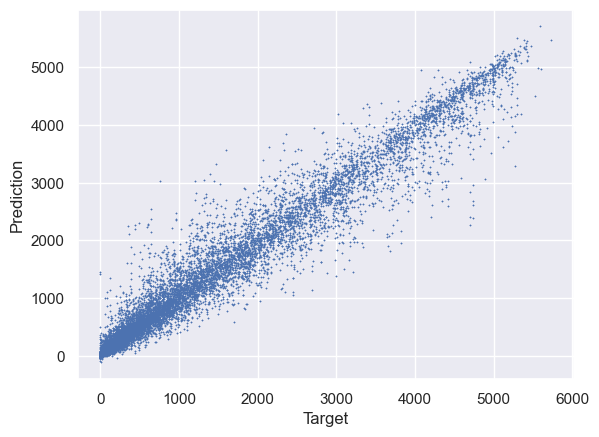

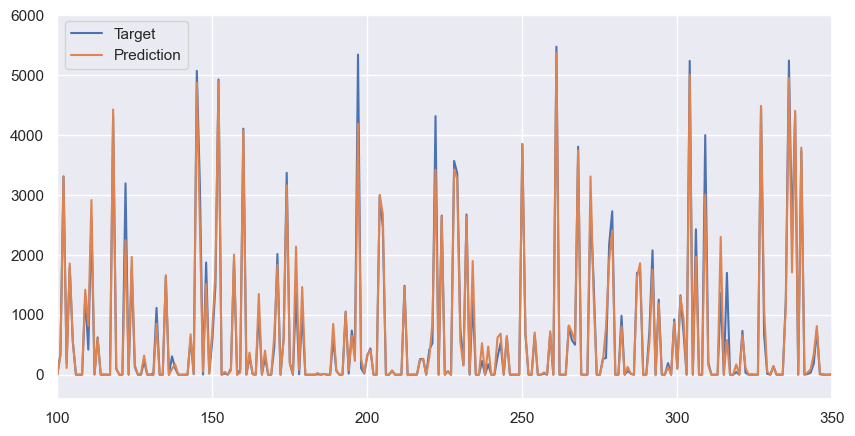

In [35]:
plt.figure()
plt.scatter(Y_test,y_pred,s=0.05,c="b",marker="*",)
plt.xlabel("Target")
plt.ylabel("Prediction")
plt.show()

plt.figure(figsize=(10, 5))
x = np.arange(0,len(Y_test))
plt.plot(x,Y_test, label = 'Target')
plt.plot(x,y_pred, label = 'Prediction')
plt.legend()
plt.xlim([100, 350])
plt.show()

This model is pretty dumb as there is no time awareness (using previous data), it is just regression on a vector. Also, we are only training using the observed data and not the forecasted one so it's not quite what we wanted. We will now use a sliding window

In [26]:
from sklearn.model_selection import TimeSeriesSplit

# Define your sliding window configuration
window_size = 4*1000  # The past 1000 hours
step_size = 4*500     # Move 500 hours forward

# Create TimeSeriesSplit with sliding window
tscv = TimeSeriesSplit(n_splits=(len(XData_selected) - window_size) // step_size + 1)

mse_scores = []

for train_index, test_index in tscv.split(XData_selected):
    # Extract the current window for training and testing
    train_indices = range(train_index[0], train_index[-1] + 1)
    test_indices = range(test_index[0], test_index[-1] + 1)

    X_train = XData_selected.iloc[train_indices]
    X_test = XData_selected.iloc[test_indices]
    Y_train = YData_selected.iloc[train_indices]
    Y_test = YData_selected.iloc[test_indices]

    # Convert data to LightGBM Dataset format
    train_data = lgb.Dataset(X_train, label=Y_train)
    test_data = lgb.Dataset(X_test, label=Y_test)

    # Set LightGBM hyperparameters
    params = {
        "objective": "regression",
        "metric": "mse",
        "num_leaves": 500,
        "learning_rate": 0.05,
    }

    # Train the LightGBM model
    model = lgb.train(params, train_data, num_boost_round=100)

    # Make predictions
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)

    # Evaluate the model
    mse = mean_squared_error(Y_test, y_pred)
    mse_scores.append(mse)

# Calculate the mean MSE across all sliding windows
mean_mse = sum(mse_scores) / len(mse_scores)
print(f"Mean Squared Error (across sliding windows): {mean_mse:.0f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000859 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2988
[LightGBM] [Info] Number of data points in the train set: 2031, number of used features: 22
[LightGBM] [Info] Start training from score 1153.849845
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

In [ ]:
y_pred = model.predict(XData_selected, num_iteration=model.best_iteration)

plt.figure()
plt.scatter(YData_selected,y_pred,s=0.05,c="b",marker="*",)
plt.xlabel("Target")
plt.ylabel("Prediction")
plt.show()

This is slower and has a higher MSE, not very good.

---
# Clean(?) data loader
Here we try to implement a cleaner version of the dataset loader. Eventually we would make this one single function

First, we read the data from the parquet files and get the low correlation columns as well as filling in the `NaN` values.

In [87]:
# Read dataframes
LOCATION = 'C'
train_target, X_train_observed, X_train_estimated, X_test_estimated = read_data_location(location = LOCATION)


# Process NaNs and highly correlated features
dataframes = [train_target,X_train_observed,X_train_estimated,X_test_estimated]
dataframe_names = ["train_target","X_train_observed","X_train_estimated","X_test_estimated"]
index = 0
FEATURES = [] # Contains the list of useful features for each dataframe

threshold = 0.9

for dataframe in dataframes:
    print("** WORKING ON "+dataframe_names[index]+"**")
    # Replace colons with underscores in column names of 'dataframe'
    dataframe.columns = dataframe.columns.str.replace(':', '_')
    # Find low find_low_correlation_columns
    features = find_low_correlation_columns(dataframe,threshold,verbose=False)
    FEATURES.append(features)
    # Fill NaN
    for feature in features:
        fill_nan(dataframe,feature)
    index+=1

** WORKING ON train_target**
Missing data in pv_measurement  size  6060  out of 32155
Filled with bfill method
** WORKING ON X_train_observed**


C:\Users\NOE\AppData\Local\Temp\ipykernel_16116\2958491047.py:150: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  new_column = Dataframe[feature].fillna(method='ffill')
C:\Users\NOE\AppData\Local\Temp\ipykernel_16116\2958491047.py:155: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  new_column = Dataframe[feature].fillna(method='bfill')


Missing data in ceiling_height_agl_m  size  19923  out of 116825
Filled with ffill method
Missing data in cloud_base_agl_m  size  8512  out of 116825
Filled with ffill method
** WORKING ON X_train_estimated**


C:\Users\NOE\AppData\Local\Temp\ipykernel_16116\2958491047.py:150: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  new_column = Dataframe[feature].fillna(method='ffill')


Missing data in ceiling_height_agl_m  size  4596  out of 17576
Filled with ffill method
Missing data in cloud_base_agl_m  size  2804  out of 17576
Filled with ffill method
** WORKING ON X_test_estimated**
Missing data in ceiling_height_agl_m  size  849  out of 2880
Filled with bfill method
Missing data in cloud_base_agl_m  size  375  out of 2880
Filled with ffill method


C:\Users\NOE\AppData\Local\Temp\ipykernel_16116\2958491047.py:150: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  new_column = Dataframe[feature].fillna(method='ffill')
C:\Users\NOE\AppData\Local\Temp\ipykernel_16116\2958491047.py:150: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  new_column = Dataframe[feature].fillna(method='ffill')
C:\Users\NOE\AppData\Local\Temp\ipykernel_16116\2958491047.py:155: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  new_column = Dataframe[feature].fillna(method='bfill')


Now we can process the datasets to select only time points where there is data in both the training and the target values.

In [88]:
Ydf = remove_consecutive_identical_values(train_target,'pv_measurement')
Xdf = pd.concat([X_train_observed,X_train_estimated]).reset_index(drop=True)

X_Train,Y_Train = select_and_resample(Xdf,Ydf)

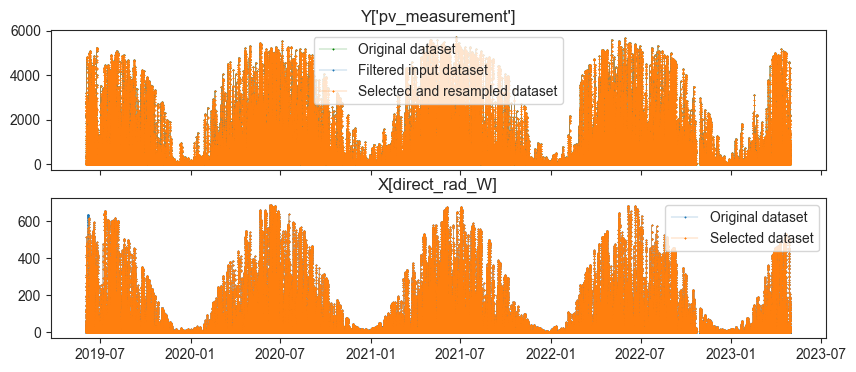

Before processing 
Y : (19466, 2)
X : (136245, 48)

After processing 
Y : (77828, 2)
X : (77828, 47)


In [59]:
# plot the difference between the original dataset and the filtered one
fig, axs = plt.subplots(figsize=(10,4), ncols=1, nrows=2, sharex=True)
axs[0].plot(train_target['time'],train_target['pv_measurement'],'-*g',linewidth = 0.2, markersize = 0.8, label = "Original dataset")
axs[0].plot(Ydf['time'],Ydf['pv_measurement'],'-*',linewidth = 0.2, markersize = 0.8, label="Filtered input dataset")
axs[0].plot(Y_Train['time'],Y_Train['pv_measurement'],'-x',linewidth = 0.2, markersize = 0.8, label = "Selected and resampled dataset")
axs[0].set_title("Y['pv_measurement']")
axs[0].legend()
axs[1].plot(Xdf['date_forecast'],Xdf['direct_rad_W'],'-*',linewidth = 0.2, markersize = 0.8, label = "Original dataset")
axs[1].plot(X_Train['date_forecast'],X_Train['direct_rad_W'],'-x',linewidth = 0.2, markersize = 0.8, label = "Selected dataset")
axs[1].set_title("X[direct_rad_W]")
axs[1].legend()

#plt.xlim([pd.Timestamp('2021-01-01'),pd.Timestamp('2021-02-01')])
plt.show()
fig.tight_layout()

print(f"Before processing \nY : {np.shape(Ydf)}\nX : {np.shape(Xdf)}\n")
print(f"After processing \nY : {np.shape(Y_Train)}\nX : {np.shape(X_Train)}")

It is now interesting to plot some statistics of the training target :

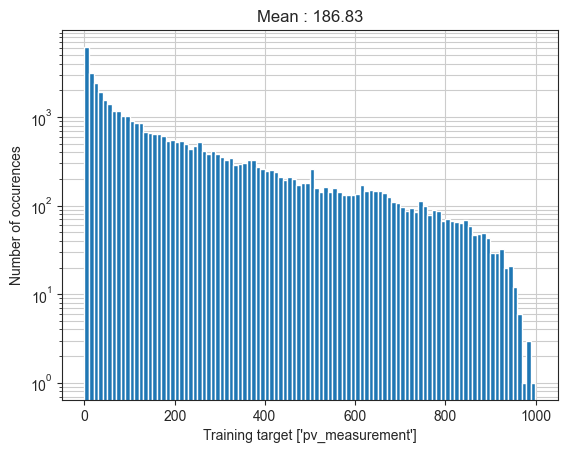

In [9]:
plt.figure()
plt.hist(Y_Train['pv_measurement'], bins=100)
plt.xlabel("Training target ['pv_measurement']")
plt.ylabel("Number of occurences")
plt.title(f"Mean : {Y_Train['pv_measurement'].mean():.2f}")
plt.yscale('log')
plt.grid(which='both')
plt.show()

There is a lot of 0

---
## Train models

There are no retarded features in the current datasets so these predictors will be simple dumb regression from a vector to a scalar without any time considerations. I am not doing any k-fold either because fuck good practices.

Also, there is absolutely zero consideration for statistics and normalization so the results can definitely be improved with better data processing

In [89]:
# Select the correct columns for the prediction
Y_train_selected = Y_Train['pv_measurement']
X_train_selected = X_Train[FEATURES[1][1:]] # do not include the 'date_forecast' column

RANDOM_SEED = 43

In [90]:
# Split training data into train and test 
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_train_selected,Y_train_selected,
                                                    test_size=0.2,
                                                    random_state=RANDOM_SEED,
                                                    shuffle=True,
                                                    )

### MLP regression (bad, do not run it)

In [35]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [36]:
# Use a MLP for regression
mlp_model = MLPRegressor(random_state=1,
                     learning_rate_init=0.05,
                     learning_rate="invscaling",
                     solver="adam",
                     hidden_layer_sizes=(100, 50),
                     activation='relu',
                     max_iter=1000,
                     n_iter_no_change=5000,
                     tol=1e-6,
                     verbose=True)
mlp_model.fit(X_train, Y_train)

plt.figure()
start_iter = 20
plt.plot(np.arange(start_iter,mlp_model.n_iter_),mlp_model.loss_curve_[start_iter:])
plt.title("Loss")
plt.show()

Iteration 1, loss = 4049184857.81884193
Iteration 2, loss = 1991293.49127562
Iteration 3, loss = 634104.96630199
Iteration 4, loss = 455463.75828616
Iteration 5, loss = 405251.98910510
Iteration 6, loss = 391095.35558629
Iteration 7, loss = 384081.66262914
Iteration 8, loss = 378491.94625842
Iteration 9, loss = 373382.77261782
Iteration 10, loss = 361781.14603071
Iteration 11, loss = 349816.87012916
Iteration 12, loss = 338195.95071730
Iteration 13, loss = 325175.43328127
Iteration 14, loss = 321072.43398875
Iteration 15, loss = 313259.27555207
Iteration 16, loss = 307859.65343563
Iteration 17, loss = 303874.17167298
Iteration 18, loss = 294728.14061304
Iteration 19, loss = 288023.79052922
Iteration 20, loss = 285713.22703088
Iteration 21, loss = 289316.56014199
Iteration 22, loss = 274825.28169719
Iteration 23, loss = 268799.12321171
Iteration 24, loss = 269519.89166929
Iteration 25, loss = 264623.46948064
Iteration 26, loss = 261228.22069522
Iteration 27, loss = 258588.71657894
Itera

In [71]:
# Make predictions
Y_pred = mlp_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(Y_test, Y_pred)
print(f"Mean Squared Error: {mse:.0f}")

Mean Squared Error: 226088


In [ ]:
plt.figure()
plt.scatter(Y_test,Y_pred,s=0.05,c="b",marker="*",)
plt.xlabel("Target")
plt.ylabel("Prediction")
plt.show()

plt.figure(figsize=(10, 5))
x = np.arange(0,len(Y_test))
plt.plot(x,Y_test, label = 'Target')
plt.plot(x,Y_pred, label = 'Prediction')
plt.legend()
plt.xlim([100, 350])
plt.show()

### LGB regression

In [15]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

In [16]:
# Convert data to LightGBM Dataset format
train_data = lgb.Dataset(X_train, label=Y_train)
test_data = lgb.Dataset(X_test, label=Y_test)

# Set LightGBM hyperparameters
params = {
    "objective": "regression",
    "metric": "mse",
    "num_leaves": 1000,
    "learning_rate": 0.05,
    "num_threads" : 2,
}

# Train the LightGBM model
lgb_model = lgb.train(params, train_data, num_boost_round=1000)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004357 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3794
[LightGBM] [Info] Number of data points in the train set: 33888, number of used features: 32
[LightGBM] [Info] Start training from score 187.665394


In [17]:
# Make predictions
Y_pred = np.asarray(lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration))

# Evaluate the model
mse = mean_squared_error(Y_test, Y_pred)
print(f"Mean Squared Error: {mse:.0f}")

Mean Squared Error: 867


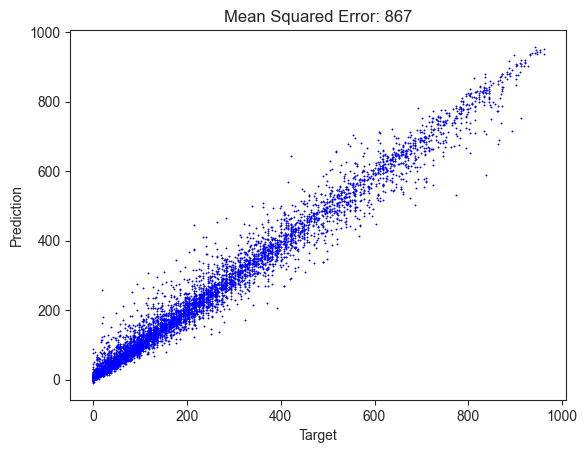

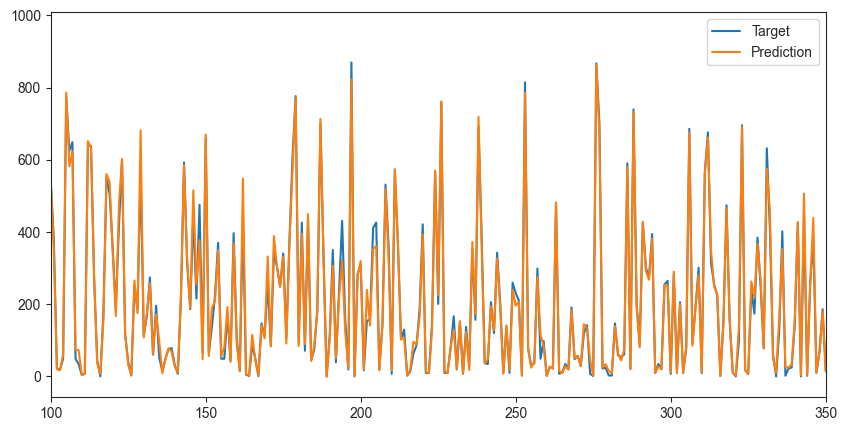

In [18]:
plt.figure()
plt.scatter(Y_test,Y_pred,s=0.05,c="b",marker="*",)
plt.xlabel("Target")
plt.ylabel("Prediction")
plt.title(f"Mean Squared Error: {mse:.0f}")
plt.show()

plt.figure(figsize=(10, 5))
x = np.arange(0,len(Y_test))
plt.plot(x,Y_test, label = 'Target')
plt.plot(x,Y_pred, label = 'Prediction')
plt.legend()
plt.xlim([100, 350])
plt.show()

### CatBoost regression

In [8]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score

Train the model

In [91]:
catboost_model = CatBoostRegressor(iterations=3000,
                          learning_rate=0.25,
                          depth=9,
                          loss_function='RMSE')

catboost_model.fit(X_train, Y_train)

0:	learn: 171.0566474	total: 74.7ms	remaining: 3m 44s
1:	learn: 141.2714511	total: 263ms	remaining: 6m 34s
2:	learn: 120.5835312	total: 358ms	remaining: 5m 57s
3:	learn: 106.3658569	total: 421ms	remaining: 5m 15s
4:	learn: 96.1243460	total: 514ms	remaining: 5m 7s
5:	learn: 89.2500588	total: 564ms	remaining: 4m 41s
6:	learn: 84.5900483	total: 641ms	remaining: 4m 33s
7:	learn: 81.2361542	total: 700ms	remaining: 4m 21s
8:	learn: 78.8513987	total: 745ms	remaining: 4m 7s
9:	learn: 76.9585143	total: 793ms	remaining: 3m 57s
10:	learn: 75.2066015	total: 829ms	remaining: 3m 45s
11:	learn: 73.7847883	total: 872ms	remaining: 3m 37s
12:	learn: 73.2275336	total: 915ms	remaining: 3m 30s
13:	learn: 72.3944612	total: 958ms	remaining: 3m 24s
14:	learn: 71.7809681	total: 994ms	remaining: 3m 17s
15:	learn: 70.5421581	total: 1.03s	remaining: 3m 11s
16:	learn: 70.1254150	total: 1.06s	remaining: 3m 6s
17:	learn: 69.5821578	total: 1.1s	remaining: 3m 2s
18:	learn: 69.2818121	total: 1.17s	remaining: 3m 2s
19:	

Test the model

MSE = 702


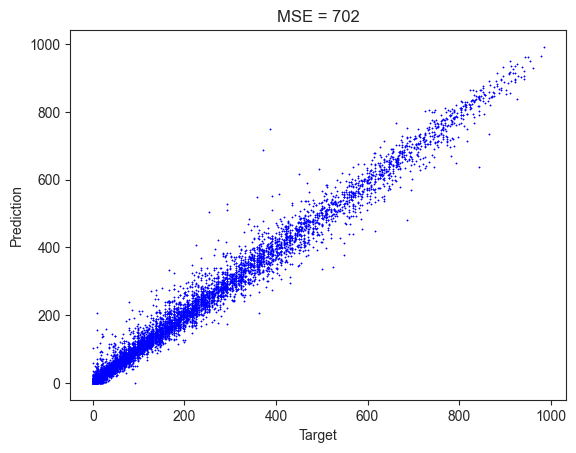

In [92]:
# Make predictions every 15 minutes
Y_pred = catboost_model.predict(X_test)
Y_pred[Y_pred<0]=0

# Get only the predictions at round hours
# retrieve the time axis
"""mask = X_Train.index.isin(X_test.index)
timestamps = X_Train.loc[mask, 'date_forecast']
# select round hours
Y_pred_hour = select_o_clock(pd.DataFrame({
    'time': timestamps,
    'pv_measurement': Y_pred
    }),'time')
Y_test_hour = select_o_clock(pd.DataFrame({
    'time': timestamps,
    'pv_measurement': Y_test
    }),'time')"""

mse = mean_squared_error(Y_test, Y_pred)
#mse_hour = mean_squared_error(Y_test_hour['pv_measurement'], Y_pred_hour['pv_measurement'])


print(f"MSE = {mse:.0f}")
#print(f"MSE (round hours)= {mse_hour:.0f}")


plt.figure()
plt.scatter(Y_test,Y_pred,s=0.05,c="b",marker="*",)
#plt.scatter(Y_test_hour['pv_measurement'],Y_pred_hour['pv_measurement'],s=0.05,c="r",marker="*",)
plt.xlabel("Target")
plt.ylabel("Prediction")
plt.title(f"MSE = {mse:.0f}")
plt.show()

In [66]:
feature_importance = catboost_model.get_feature_importance(prettified=True)
print(feature_importance)

                        Feature Id  Importances
0                     direct_rad_W    19.956196
1                    sun_azimuth_d    10.867942
2                  sun_elevation_d     9.442524
3                 msl_pressure_hPa     7.360330
4            clear_sky_energy_1h_J     6.385715
5         absolute_humidity_2m_gm3     5.668029
6              wind_speed_u_10m_ms     5.185114
7             ceiling_height_agl_m     5.084451
8          effective_cloud_cover_p     4.478169
9              wind_speed_v_10m_ms     3.948387
10             air_density_2m_kgm3     3.930173
11                cloud_base_agl_m     3.795717
12                    visibility_m     3.698153
13     relative_humidity_1000hPa_p     3.665947
14               wind_speed_10m_ms     3.447643
15                 snow_water_kgm2     0.920547
16  super_cooled_liquid_water_kgm2     0.828909
17            precip_type_5min_idx     0.405691
18               fresh_snow_24h_cm     0.340831
19                  precip_5min_mm     0

We can try to train again using only the top 20 feature for example and see if it leads to better results

I did it and it was not convincing.

---
## Tests

In [81]:
# Prediction on the whole training dataset (dumb)
Y = catboost_model.predict(X_Train[FEATURES[1][1:]])
Y[Y<0]=0

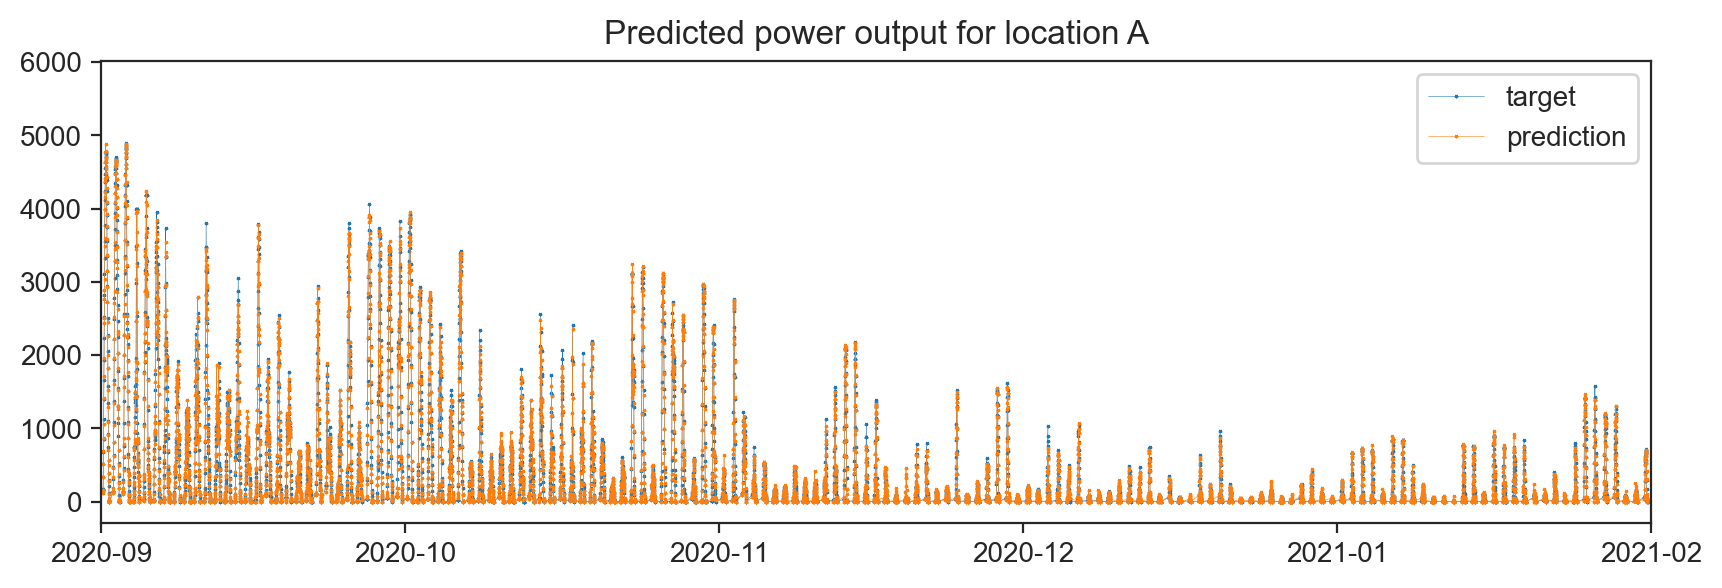

In [88]:
plt.figure(figsize=(10,3),dpi=200)
plt.plot(X_Train['date_forecast'],Y_Train['pv_measurement'],'-*',linewidth = 0.2, markersize = 0.8, label = 'target')
plt.plot(X_Train['date_forecast'],Y, '-*', linewidth = 0.2, markersize = 0.8, label = 'prediction')
plt.title(f"Predicted power output for location {LOCATION}")
plt.legend()
plt.xlim([pd.to_datetime('2020-09-01'),pd.to_datetime('2021-02-01')])
plt.show()

## Make a prediction for Kaggle

In [93]:
# Predict on the X_test_estimated dataset
Y_test_estimated = pd.DataFrame()
pv_measurement =  catboost_model.predict(X_test_estimated[FEATURES[1][1:]])
pv_measurement[pv_measurement<0]=0
Y_test_estimated['prediction'] = pv_measurement

Y_test_estimated['time'] = X_test_estimated['date_forecast']
Y_test_estimated_round = select_o_clock(Y_test_estimated,'time')
Y_test_estimated_round['location'] = LOCATION


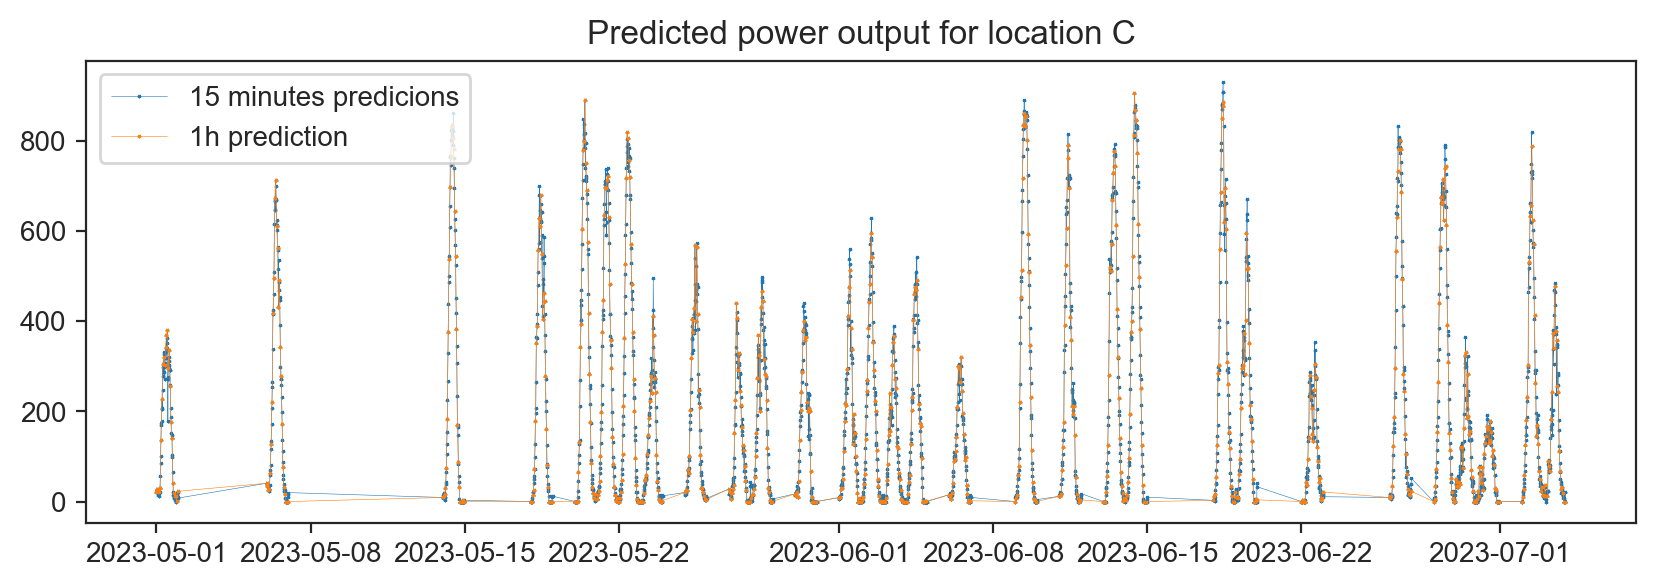

In [94]:
plt.figure(figsize=(10,3),dpi=200)
plt.plot(Y_test_estimated['time'],Y_test_estimated['prediction'],'-*',linewidth = 0.2, markersize = 0.8, label="15 minutes predicions")
plt.plot(Y_test_estimated_round['time'],Y_test_estimated_round['prediction'],'-*',linewidth = 0.2, markersize = 0.8, label="1h prediction")
plt.title(f"Predicted power output for location {LOCATION}")
plt.legend()
#plt.xlim([pd.to_datetime('2023-05-01'),pd.to_datetime('2023-05-02')])
plt.show()

In [111]:
sample_submission = pd.read_csv('my_first_submission_utf8.csv')
sample_submission

,id,time,prediction,location
0,0,01/05/2023 00:00,12.524005,A
1,1,01/05/2023 01:00,0.000000,A
2,2,01/05/2023 02:00,33.329530,A
3,3,01/05/2023 03:00,33.559831,A
4,4,01/05/2023 04:00,288.622116,A
...,...,...,...,...
2155,2155,03/07/2023 19:00,26.893763,C
2156,2156,03/07/2023 20:00,31.432740,C
2157,2157,03/07/2023 21:00,19.568391,C
2158,2158,03/07/2023 22:00,0.000000,C


In [96]:
# Example, let the predictions be random values
submission = pd.concat([sample_submission,Y_test_estimated_round[['time','prediction','location']]])
submission.to_csv('my_first_submission.csv', index=False)


In [105]:
sample_submission = pd.read_csv('my_first_submission.csv')
sorted_submission = sample_submission.sort_values(by='location').reset_index(drop=True)
sorted_submission['id'] = sorted_submission.index
sorted_submission = sorted_submission[['id','time','prediction','location']]
sorted_submission.to_csv('submission1.csv', index=False, encoding='utf8')

In [112]:
sample_submission.to_csv('my_first_submission_utf8.csv',columns=['id','prediction'], index=False, encoding='utf8')